In [1]:
import re
import pickle
import warnings
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Tuple

from dateutil.relativedelta import relativedelta

from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# from tensorflow.random import set_seed

# set_seed(0)

In [2]:
df = pd.read_csv('data_for_train/consumption_and_temperature_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('datetime', inplace=True)
print('df.shape', df.shape)
df.head(2)

df.shape (64992, 2)


,one_hour_consumption,one_hour_temperature
datetime,,
2016-01-01 00:00:00,3962.983333,-8.313333
2016-01-01 01:00:00,3808.266667,-8.260000


In [3]:
calendar = pd.read_excel('data_for_train/calendar.xlsx', index_col='day')
print('calendar.shape', calendar.shape)
calendar.head(7)

calendar.shape (2922, 1)


,day_off
day,
2016-01-01,1
2016-01-02,1
2016-01-03,1
2016-01-04,0
2016-01-05,0
2016-01-06,0
2016-01-07,1


Для предсказания потребления воспользуемся рекуррентной нейронной сетью, созданной с помощью tensorflow.keras. Подготовим данные:

In [ ]:
def make_data(df               : pd.DataFrame,
              calendar         : pd.DataFrame,
              y_lags           : List[int],
              time_freq        : List[str],
              ) -> pd.DataFrame:
    """
    Функция, формирующая датасет для обучения рекуррентной нейронной сети.
    На вход требует:

    Датафрейм df, содержащий данные о почасовом потреблении и темпераутре.

    Датафрейм calendar, содержащий данные о том, выходной день или нет.

    Список лагов для целевой переменной, по которым будет осуществляться сдвиг во времени вперед.
    Рекомендуется давать начиная с единицы. Последнее значение не включается.

    Список частот, по которым необходимо кодировать текущую время и дату.
    Доступны: {'hour', 'day_of_year', 'month', 'weekday'}

    Логическое значение True/False на включение в датасет целевой переменной.
    """
    time_dict = {'hour'        : 24,
                 'day_of_year' : 365.25,
                 'month'       : 12,
                 'weekday'     : 7}

    # так как планируется применять данную функцию и для подготовки данных для предсказания
    # без известного заранее результата, раширим датафрейм вперед, для того, чтобы знать дату и время
    new_index = pd.date_range(start=df.index[-1], periods=y_lags[-1] + 1, freq='H')[y_lags[0] + 1:]
    df = pd.concat([df, pd.DataFrame(index=new_index)])

    # присоединим информацию о выходных и рабочих днях
    df['date'] = pd.to_datetime(df.index.date, format='%Y-%m-%d')
    df = pd.merge(df, calendar, left_on='date', right_index=True, how='left')
    df.drop('date', axis=1, inplace=True)

    # извлечем тригонометрическую фичу из времени
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for time_component in time_freq:
            df[time_component] = getattr(df.index, time_component)
            df[f'{time_component}_sin'] = np.sin( 2 * np.pi * df[time_component] / time_dict[time_component])
            df[f'{time_component}_cos'] = np.cos( 2 * np.pi * df[time_component] / time_dict[time_component])
            df.drop([time_component], axis=1, inplace=True)

    # в конце добавим нашу целевую переменную
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for lag in y_lags:
            df[f'y_{lag}'] = df['one_hour_consumption'].shift(-lag - 1)
    
    # удалим строки, содержащие Nan
    df.dropna(axis=0, inplace=True)

    return df

In [ ]:
y_lags=list(range(12, 36))
time_freq = ['hour', 'day_of_year', 'month', 'weekday']

dataset = make_data(df               =df,
                    calendar         =calendar,
                    y_lags           =y_lags,
                    time_freq        =time_freq)

pd.set_option("display.max_columns", dataset.shape[-1])
print('dataset.shape', dataset.shape)

dataset.to_csv('data_for_train/3.4/dataset.csv')

In [4]:
dataset = pd.read_csv('data_for_train/3.4/dataset.csv', index_col=0)
dataset.index = pd.to_datetime(dataset.index, format='%Y-%m-%d %H:%M:%S')
print('dataset.shape', dataset.shape)
dataset.head(2)

dataset.shape (64956, 35)


,one_hour_consumption,one_hour_temperature,day_off,hour_sin,hour_cos,day_of_year_sin,day_of_year_cos,month_sin,month_cos,weekday_sin,...,y_26,y_27,y_28,y_29,y_30,y_31,y_32,y_33,y_34,y_35
2016-01-01 00:00:00,3962.983333,-8.313333,1,0.000000,1.000000,0.017202,0.999852,0.5,0.866025,-0.433884,...,3245.683333,3257.5,3308.300000,3529.983333,3678.066667,3716.750000,3786.366667,3915.383333,4138.483333,4115.7
2016-01-01 01:00:00,3808.266667,-8.260000,1,0.258819,0.965926,0.017202,0.999852,0.5,0.866025,-0.433884,...,3257.500000,3308.3,3529.983333,3678.066667,3716.750000,3786.366667,3915.383333,4138.483333,4115.700000,4070.2


In [ ]:
pd.DataFrame(dataset.loc['2023-05-30 11:00:00']).T

In [ ]:
df.loc['2023-05-31 00:00:00', 'one_hour_consumption'], \
df.loc['2023-05-31 23:00:00', 'one_hour_consumption']

Разделим данные на тренировочную и тестовую выборки:

In [5]:
window_size = 179

In [ ]:
df_train = dataset.loc[:'2022-11-30 10:00:00'].copy()
df_test = dataset.loc[pd.to_datetime('2022-11-30 11:00:00') - relativedelta(hours=window_size):].copy()

Применим StandardScaler к колонкам с потреблением и температурой. Сохраним объект скеллера.

In [ ]:
scaller = StandardScaler()

df_train.loc[:, ['one_hour_consumption', 'one_hour_temperature']] = scaller \
    .fit_transform(df_train.loc[:, ['one_hour_consumption', 'one_hour_temperature']].values.reshape(-1, 2))

df_test.loc[:, ['one_hour_consumption', 'one_hour_temperature']] = scaller \
    .transform(df_test.loc[:, ['one_hour_consumption', 'one_hour_temperature']].values.reshape(-1, 2))

with open(f'models/3.4/scaller.pickle', 'wb') as file:
    pickle.dump(scaller, file)

Для генерации обучающих примеров напишем еще одну функцию:

In [ ]:
def generate_sequences(df          : pd.DataFrame,
                       window_size : int,
                       pred_cols   : List[str],
                       target_cols : List[str]) -> Tuple[np.array]:
    """
    Возвращает обучающие примеры для RNN.

    Принимает на вход датафрейм с данными.

    Размер окна, который представляет собой размер предыстории начиная от
    момента времени, в который осуществляеся предсказание.

    Перечень колонок-предикторов и целевых колонок.
    """
    df.reset_index(drop=True, inplace=True)
    start_index = window_size

    sequence = []
    target = []

    input_shape = (-1, window_size + 1, len(pred_cols))
    output_shape = (-1, len(target_cols))

    while start_index < len(df):
        sequence.append(df.iloc[start_index - window_size:start_index + 1][pred_cols])
        target.append(df.iloc[start_index][target_cols])

        start_index += 1
    
    sequence = np.array(sequence).reshape(input_shape)
    target = np.array(target).reshape(output_shape)

    return sequence, target

Определим размерность входных и выходных данных.

In [6]:
y_regex = r'y_(\d+)'

pred_cols = []
target_cols = []

pred_cols.extend([col_name for col_name in dataset.columns if not re.match(y_regex, col_name)])
target_cols.extend([col_name for col_name in dataset.columns if re.match(y_regex, col_name)])

input_shape = (window_size + 1, len(pred_cols))
output_shape = len(target_cols)

input_shape, output_shape

((180, 11), 24)

Обучающая и тестовая выборки:

In [ ]:
X_train, y_train = generate_sequences(df=df_train,
                                      window_size=window_size,
                                      pred_cols=pred_cols,
                                      target_cols=target_cols)

X_test, y_test = generate_sequences(df=df_test,
                                    window_size=window_size,
                                    pred_cols=pred_cols,
                                    target_cols=target_cols)

# сохраним объект в памяти
train_test_object = (X_train, X_test, y_train, y_test)
with open(f'data_for_train/3.4/train_test_data.pickle', 'wb') as file:
    pickle.dump(train_test_object, file)

In [7]:
# прочитаем объект из памяти
with open(f'data_for_train/3.4/train_test_data.pickle', 'rb') as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

In [9]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Conv1D, MaxPooling1D, Flatten, Dense, LSTM
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model

Для предсказания создадим простейшую модель:

In [7]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(SimpleRNN(units=64, activation='relu'))
model.add(Dense(units=output_shape))

model.compile(optimizer='adam', loss='mse', metrics=["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 178, 32)           1088      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 89, 32)           0         
 )                                                               
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                6208      
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
Total params: 8,856
Trainable params: 8,856
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model = load_model('models/3.4/model_117.968_val_mae.h5')
# model.summary()

Немного усложним модель. Добавим больше полносвязных слоев в конце.

In [ ]:
model = Sequential()

model.add(Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(SimpleRNN(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=output_shape))

model.compile(optimizer='adam', loss='mse', metrics=["mae"])

model.summary()

In [ ]:
# model = load_model('models/3.4/model_104.392_val_mae.h5')
# model.summary()

Сделаем большую свёртку.

In [7]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(SimpleRNN(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=output_shape))

model.compile(optimizer='adam', loss='mse', metrics=["mae"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 178, 64)           2176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 89, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 87, 32)            6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 43, 32)           0         
 1D)                                                             
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                6208      
                                                                 
 dense (Dense)               (None, 64)                4

In [ ]:
# model = load_model('models/3.4/model_97.382_val_mae.h5')
# model.summary()

Добавим больше слоёв RNN.

In [22]:
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=input_shape))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(SimpleRNN(units=128, activation='relu', return_sequences=True))
model.add(SimpleRNN(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=output_shape))

model.compile(optimizer='adam', loss='mse', metrics=["mae"])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 178, 64)           2176      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 89, 64)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 87, 32)            6176      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 43, 32)           0         
 1D)                                                             
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 43, 128)           20608     
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 64)               

In [ ]:
# model = load_model('models/3.4/model_98.758_val_mae.h5')
# model.summary()

In [ ]:
callbacks = [EarlyStopping(patience=10, restore_best_weights=True),
             TensorBoard(log_dir=f'logs/run_{datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}'),
             ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),]

model.fit(x=X_train,
          y=y_train,
          batch_size=16,
          epochs=100,
          validation_data=(X_test, y_test),
          callbacks=callbacks)

Напишем функцию для тестирования и сохранения модели:

In [12]:
def test_and_save_model(model,
                        X_train :np.ndarray,
                        X_test  :np.ndarray,
                        y_train :np.ndarray,
                        y_test  :np.ndarray,
                        index   :pd.date_range) -> Tuple[pd.DataFrame]:
    """
    Функция для тестирования и сохранения модели
    Необходимо передать саму модель
    данные, на которых она обучалась и тестировалась
    диапазон дат для индесирования вызодного датафрейма

    Возвращает датафреймы, по которым можно рисовать графики
    """
    # для сопосталения данных выберем среди всех тестовых примеров те,
    # которые соответствуют полным суткам
    X_train_for_metrics = X_train[::24]
    X_test_for_metrics = X_test[::24]
    
    y_true_train_for_metrics = y_train[::24]
    y_true_test_for_metrics = y_test[::24]

    y_pred_train_for_metrics = model.predict(X_train_for_metrics)
    y_pred_test_for_metrics = model.predict(X_test_for_metrics)

    mae_test = mean_absolute_error(y_true_test_for_metrics, y_pred_test_for_metrics).round(3)

    print('MSE_train:', mean_squared_error(y_true_train_for_metrics, y_pred_train_for_metrics).round(3))
    print('MAE_train:', mean_absolute_error(y_true_train_for_metrics, y_pred_train_for_metrics).round(3))

    print('MSE_test :', mean_squared_error(y_true_test_for_metrics, y_pred_test_for_metrics).round(3))
    print('MAE_test :', mae_test)

    model.save(f'models/3.4/model_{mae_test}_val_mae.h5')

    # сформируем датафреймы
    df_true = pd.DataFrame(index = index, data = y_true_test_for_metrics)
    df_pred = pd.DataFrame(index = index, data = y_pred_test_for_metrics)

    return df_true, df_pred


In [13]:
def plot_predicts(df_true   : pd.DataFrame,
                  df_pred   : pd.DataFrame,
                  days_shift: int = 1) -> None:
    """
    Функция для отображения графиков
    принимает на вход датафреймы с инедксами с дневной резолюцией и 24 колнками,
    а также число дней, на которые нужно сдвинуть индексы для отображения
    """
    date_start = (df_true.index[0] + datetime.timedelta(days=days_shift)).date()
    date_end = (df_true.index[-1] + datetime.timedelta(days=days_shift)).date()

    print(f'Реальные и предсказанные значения за период {date_start} - {date_end}'.center(180, "-"))

    _, axes = plt.subplots(nrows=len(df_true)//7,
                           ncols=7,
                           figsize=(14, 2*len(df_true)//7 + 3))

    for i in range(len(df_true)//7):

        for j in range(7):

            ax = axes[i, j]

            ax.plot(range(24), df_true.iloc[i*7 + j], color='blue')
            ax.plot(range(24), df_pred.iloc[i*7 + j], alpha=0.5, color='red')
            
            ax.set_xticks(range(0, 24, 4))
            ax.set_yticks([])

            date = (df_true.index[i*7 + j] + datetime.timedelta(days=days_shift)).date()
            mae = mean_absolute_error(df_true.iloc[i*7 + j], df_pred.iloc[i*7 + j]).round(3)
            new_line = '\n'
            ax.set_title(f'{date}{new_line}MAE: {mae}')

    plt.tight_layout()
    plt.show()

    return None

Наилучшая модель из выше приведенных 3-я по счёту. Анализ ее результатов показывает, что основную проблему для молели составляет предсказание на предстоящие нехарактерные сутки (например, случайный выходной день, связанный с государственным праздником или переносом трудовго дня). Данный класс моделей не способен предсказывать на порядок лучше при таком же подходе по формированию исходных данных. А усложнение сети в 5 - 10 раз (по числуу весов) может принести снижение MAE на считанные единицы, однако это не рационально.

In [18]:
model = load_model('models/3.4/model_97.382_val_mae.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 178, 64)           2176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 89, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 87, 32)            6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 43, 32)           0         
 1D)                                                             
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                6208      
                                                                 
 dense (Dense)               (None, 64)                4

In [16]:
index = pd.date_range(start='2022-12-01', end='2023-05-31', freq='D')

df_true, df_pred = test_and_save_model(model,
                                       X_train=X_train,
                                       X_test=X_test,
                                       y_train=y_train,
                                       y_test=y_test,
                                       index=index)

6/6 [==============================] - 0s 9ms/step
MSE_train: 12759.603
MAE_train: 81.985
MSE_test : 19396.206
MAE_test : 97.382


--------------------------------------------------------Реальные и предсказанные значения за период 2022-12-01 - 2023-05-31---------------------------------------------------------


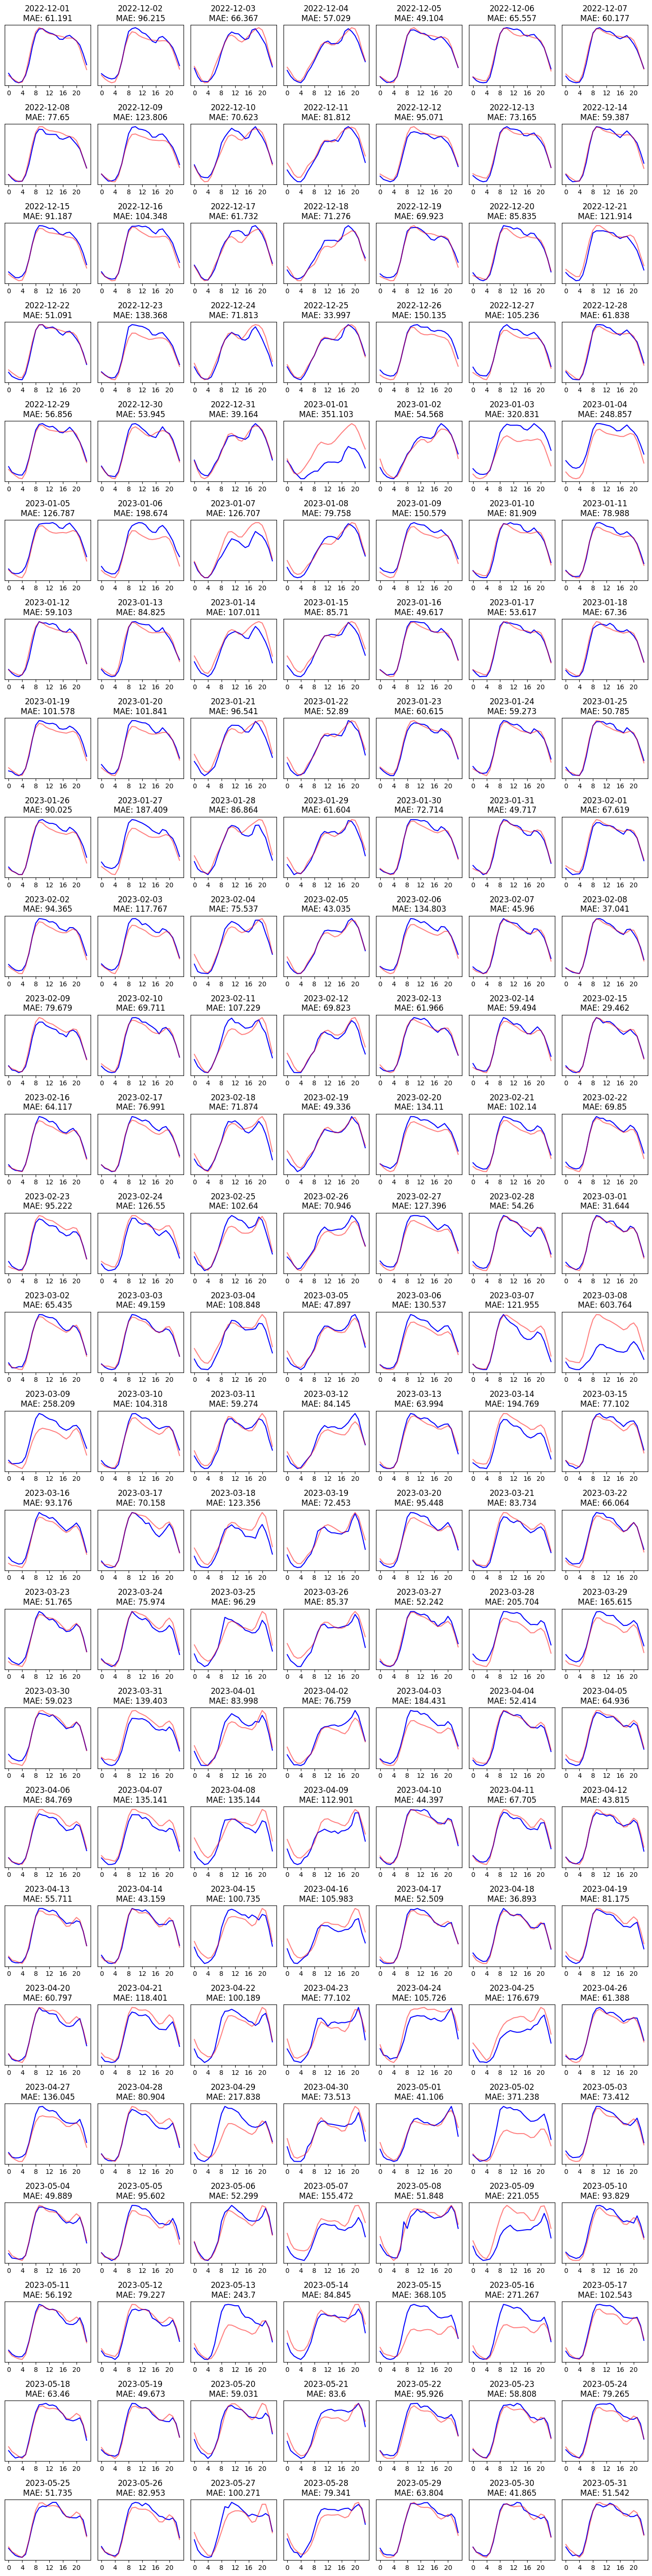

In [17]:
plot_predicts(df_true=df_true,
              df_pred=df_pred,
              days_shift=0)

Итоговый MAE на тестовых данных составил 97.382